In [46]:
import random

import pandas as pd
import numpy as np
import arviz as az
import pylab as plt
import statsmodels.api as sm

from tqdm import tqdm
from pymc3 import *
from scipy.stats import norm, ttest_ind
from scipy.interpolate import interp1d

import simulate_data.simulate_data as sd
import analysis_code.run_linear_data_analysis as rlda

In [2]:
ITERATIONS = 1000
TUNE = 2000
N_POST_SAMPLES = 50#100
NUMBER_OF_PREDICTORS = 10
RANDOM_SEED = 3#58

Y_0_1_NOISE = 1#0.3
LOG_ODDS_NOISE = 0.3

N_IN_STUDY = 500

In [3]:
iterations=ITERATIONS
tune=TUNE
n_post_samples=N_POST_SAMPLES
n_predictors=NUMBER_OF_PREDICTORS
n_in_study=N_IN_STUDY
y_0_1_noise=Y_0_1_NOISE
log_odds_noise=LOG_ODDS_NOISE
seed=RANDOM_SEED

In [4]:
# Create the Data
linear_data, true_beta_propensity_scores, true_beta_response, predictors = sd.make_basic_linear_data(
    p=n_predictors, N=n_in_study, 
    y_0_1_noise_scale=y_0_1_noise, 
    random_seed = seed
)
print(true_beta_propensity_scores)
print(sum(linear_data['T'])/linear_data.shape[0])
#Initialize Analysis Object
analysis_obj = rlda.linear_model_analysis(
    linear_data, 
    true_beta_propensity_scores, 
    true_beta_response, 
    predictors
)
# Fit Propensity Model
analysis_obj.fit_propensity_score_model(niter=iterations, tune=tune)
# Get Posterior of Propensity Model
ps_post_pred = analysis_obj.get_posterior_predictive(
    model_in=analysis_obj.propensity_score_model, 
    trace_in = analysis_obj.propensity_score_trace,
    var_names_in = ['propensity_score'])
# Fit Y_I_star Model with Mean Propensity Score
Y_i_star_mean_propensity_linear_model_model, Y_i_star_mean_propensity_linear_model_trace = (
    analysis_obj.fit_Y_i_star_mean_propensity_linear_model(niter=iterations, tune=tune))
# Fit Y_I_star Model with True Propensity Score
Y_i_star_true_propensity_linear_model_model, Y_i_star_true_propensity_linear_model_trace =(
    analysis_obj.fit_Y_i_star_true_propensity_linear_model(niter=iterations, tune=tune))

[-8.84161376e-05 -7.76140260e-01 -3.12357180e-02 -9.31388945e-03
 -4.92500800e-01  6.44894773e-01 -5.56108959e-01  5.53326254e-01
 -5.00256578e-01 -8.81510540e-01]
0.482


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, Beta]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, Beta]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 23 seconds.


In [5]:
# Fit Y_i_star Model with Posterior Based Propensity Scores
analysis_obj.fit_Y_i_star_posterior_based_model(niter=iterations, tune=tune, n_post_samples=n_post_samples)

100%|██████████| 50/50 [27:50<00:00, 33.41s/it]


Text(0.5, 0, 'True P(T=1)')

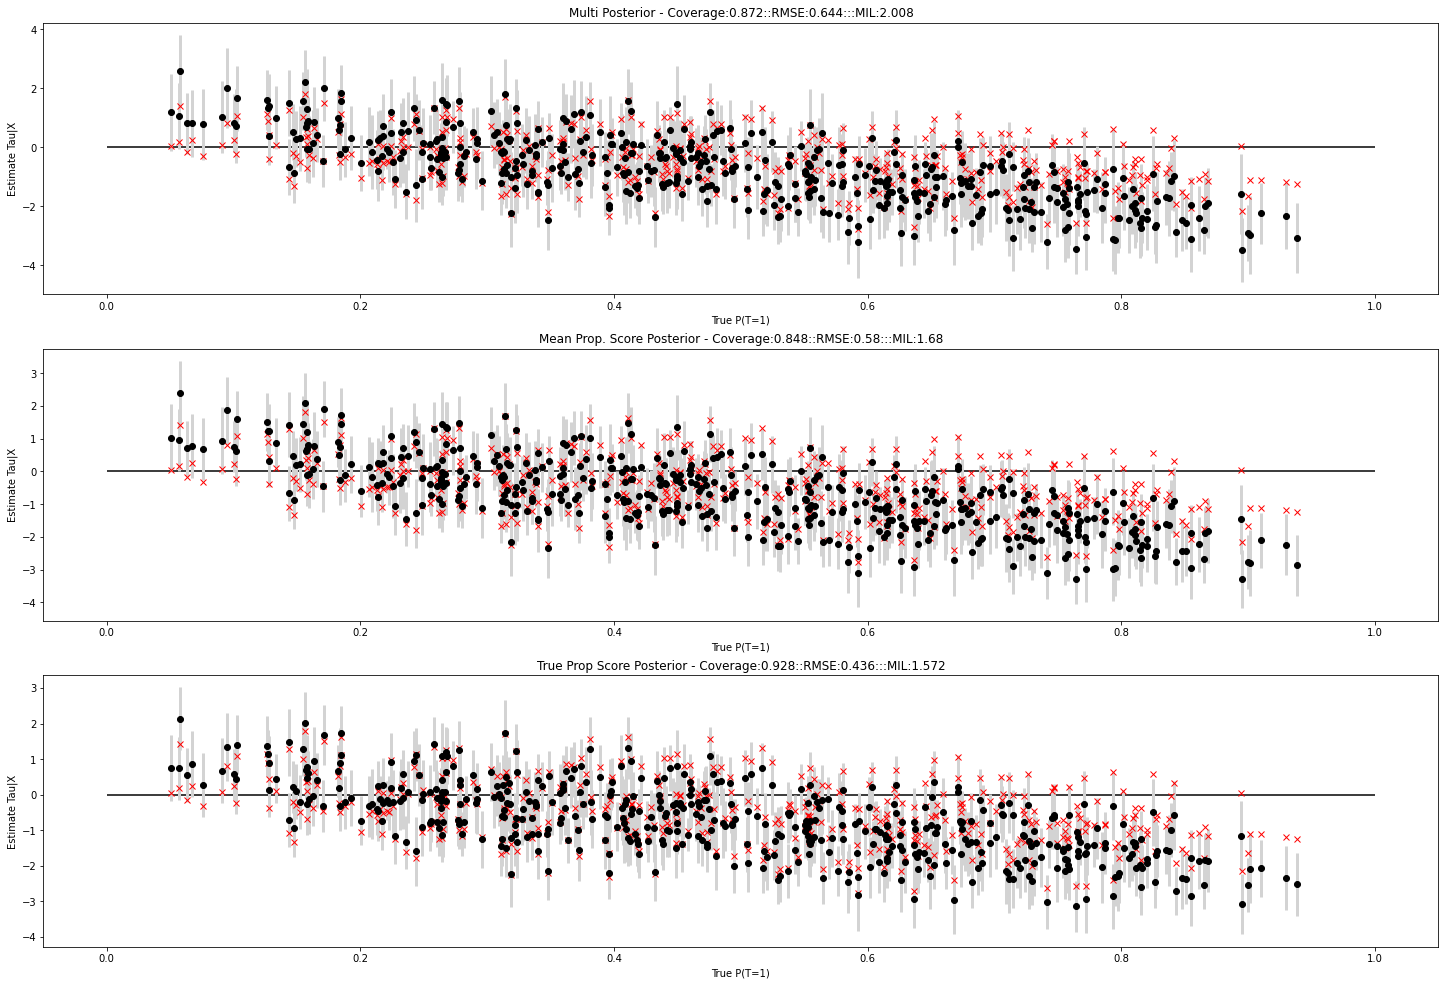

In [6]:
sub_N = n_in_study-1
X=analysis_obj.data[analysis_obj.predictors]
posterir_fp_Tau = np.matmul(
    X.to_numpy(), 
    analysis_obj.Y_i_star_posterior_propensity_linear_model_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)

plt.figure(figsize=(25,17))
## PLOT 1
plt.subplot(3, 1, 1)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
temp_fp = fp_Tau.loc[:, :sub_N]
x=analysis_obj.data.loc[:,'P(T=1)']
y=fp_Tau.mean(axis=0)
interval_high = np.quantile(fp_Tau, q=0.95, axis=0)
interval_low = np.quantile(fp_Tau, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x", color='red')
mp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
mp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_mp = 1-(sum(mp_max_violation)+sum(mp_min_violation))/len(mp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
emp = fp_Tau.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(emp*emp)), 3))    
_=plt.title("Multi Posterior - Coverage:" + str(coverage_mp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True P(T=1)')

## PLOT 2
plt.subplot(3, 1, 2)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
post_mean_Y_i_star_mean_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_mean_propensity_linear_model_model, 
    trace_in=Y_i_star_mean_propensity_linear_model_trace, 
    predictors=predictors))
x=analysis_obj.data.loc[:,'P(T=1)']
y=post_mean_Y_i_star_mean_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x", color='red')
sp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
sp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_sp = 1-(sum(sp_max_violation)+sum(sp_min_violation))/len(sp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
esp = post_mean_Y_i_star_mean_propensity_linear_model_trace.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(esp*esp)), 3))    
_=plt.title("Mean Prop. Score Posterior - Coverage:" + str(coverage_sp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True P(T=1)')

## PLOT 3
plt.subplot(3, 1, 3)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
post_mean_Y_i_star_true_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_true_propensity_linear_model_model, 
    trace_in=Y_i_star_true_propensity_linear_model_trace, 
    predictors=predictors))
x=analysis_obj.data.loc[:,'P(T=1)']
y=post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x", color='red')
tp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
tp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_tp = 1-(sum(tp_max_violation)+sum(tp_min_violation))/len(tp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
etp = post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(etp*etp)), 3))    
_=plt.title("True Prop Score Posterior - Coverage:" + str(coverage_tp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True P(T=1)')


### Estimated Tau|X vs True Tau|X with 90% Cred. Intevals

Text(0.5, 0, 'True Tau')

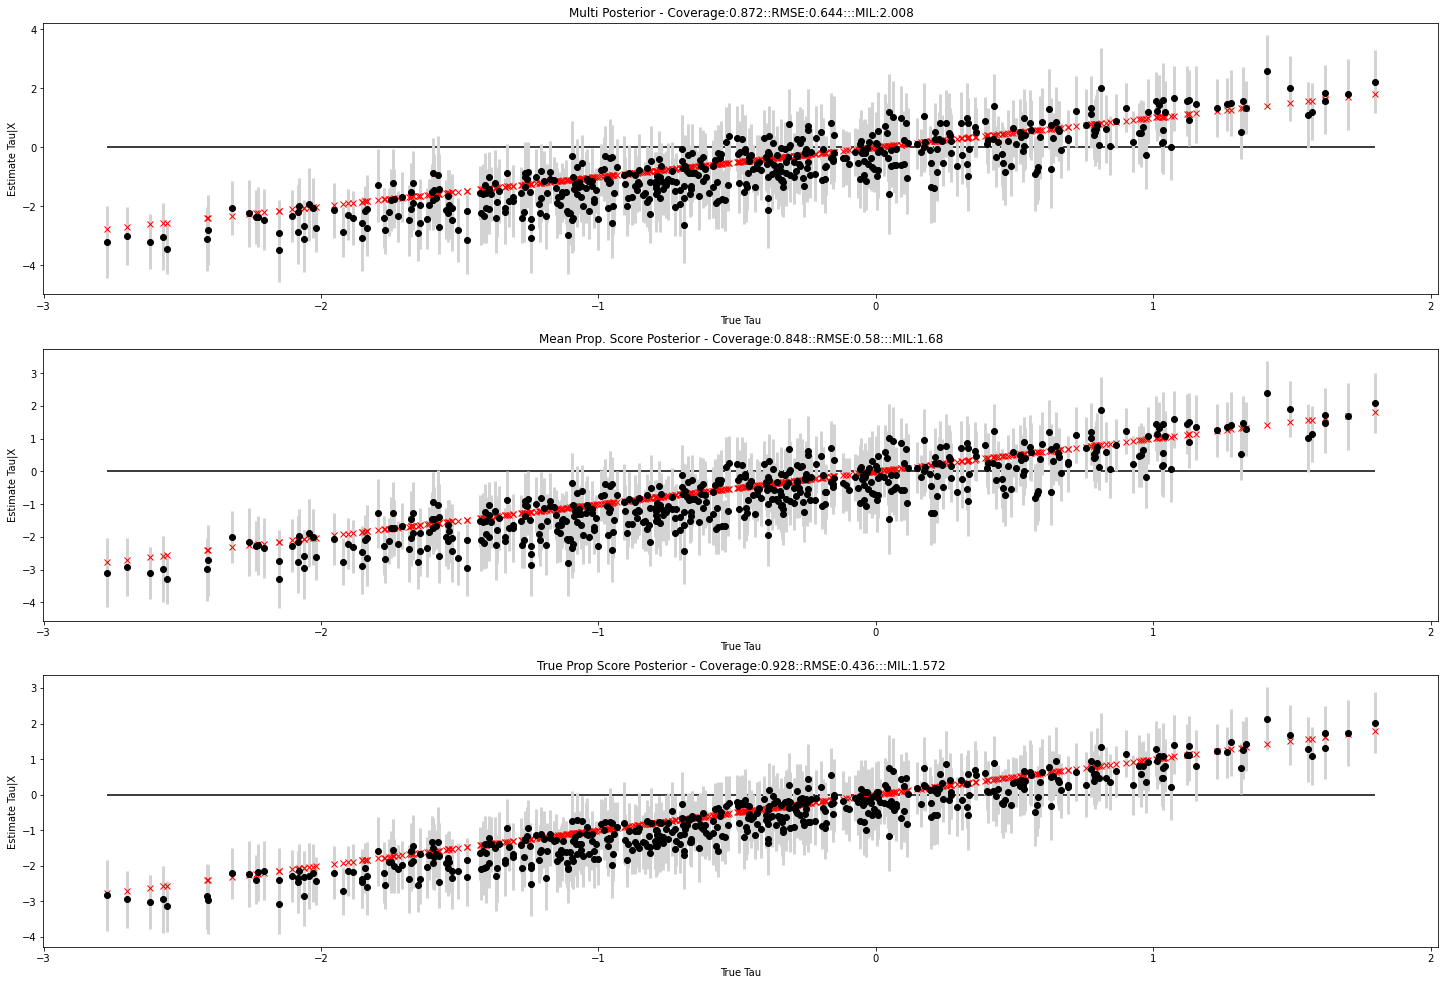

In [7]:
sub_N = n_in_study-1
X=analysis_obj.data[analysis_obj.predictors]
posterir_fp_Tau = np.matmul(
    X.to_numpy(), 
    analysis_obj.Y_i_star_posterior_propensity_linear_model_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)

plt.figure(figsize=(25,17))
## PLOT 1
plt.subplot(3, 1, 1)
plt.hlines(
    0, xmin=min(analysis_obj.data.loc[:,'Tau']), 
    xmax=max(analysis_obj.data.loc[:,'Tau'])
    , colors='k', linestyles='solid')
temp_fp = fp_Tau.loc[:, :sub_N]
x=analysis_obj.data.loc[:,'Tau']
y=fp_Tau.mean(axis=0)
interval_high = np.quantile(fp_Tau, q=0.95, axis=0)
interval_low = np.quantile(fp_Tau, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x", color='red')
mp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
mp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_mp = 1-(sum(mp_max_violation)+sum(mp_min_violation))/len(mp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
emp = fp_Tau.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(emp*emp)), 3))    
_=plt.title("Multi Posterior - Coverage:" + str(coverage_mp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True Tau')

## PLOT 2
plt.subplot(3, 1, 2)
plt.hlines(
    0, xmin=min(analysis_obj.data.loc[:,'Tau']), 
    xmax=max(analysis_obj.data.loc[:,'Tau'])
    , colors='k', linestyles='solid')
post_mean_Y_i_star_mean_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_mean_propensity_linear_model_model, 
    trace_in=Y_i_star_mean_propensity_linear_model_trace, 
    predictors=predictors))
x=analysis_obj.data.loc[:,'Tau']
y=post_mean_Y_i_star_mean_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x",color='red')
sp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
sp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_sp = 1-(sum(sp_max_violation)+sum(sp_min_violation))/len(sp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
esp = post_mean_Y_i_star_mean_propensity_linear_model_trace.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(esp*esp)), 3))    
_=plt.title("Mean Prop. Score Posterior - Coverage:" + str(coverage_sp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True Tau')

## PLOT 3
plt.subplot(3, 1, 3)
plt.hlines(
    0, xmin=min(analysis_obj.data.loc[:,'Tau']), 
    xmax=max(analysis_obj.data.loc[:,'Tau'])
    , colors='k', linestyles='solid')
post_mean_Y_i_star_true_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_true_propensity_linear_model_model, 
    trace_in=Y_i_star_true_propensity_linear_model_trace, 
    predictors=predictors))
x=analysis_obj.data.loc[:,'Tau']
y=post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x",color='red')
tp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
tp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_tp = 1-(sum(tp_max_violation)+sum(tp_min_violation))/len(tp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
etp = post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(etp*etp)), 3))    
_=plt.title("True Prop Score Posterior - Coverage:" + str(coverage_tp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True Tau')

### Credible Interval Length vs p-hat (Estimated P(T=1) )

Text(0.5, 0, 'True P(T=1)')

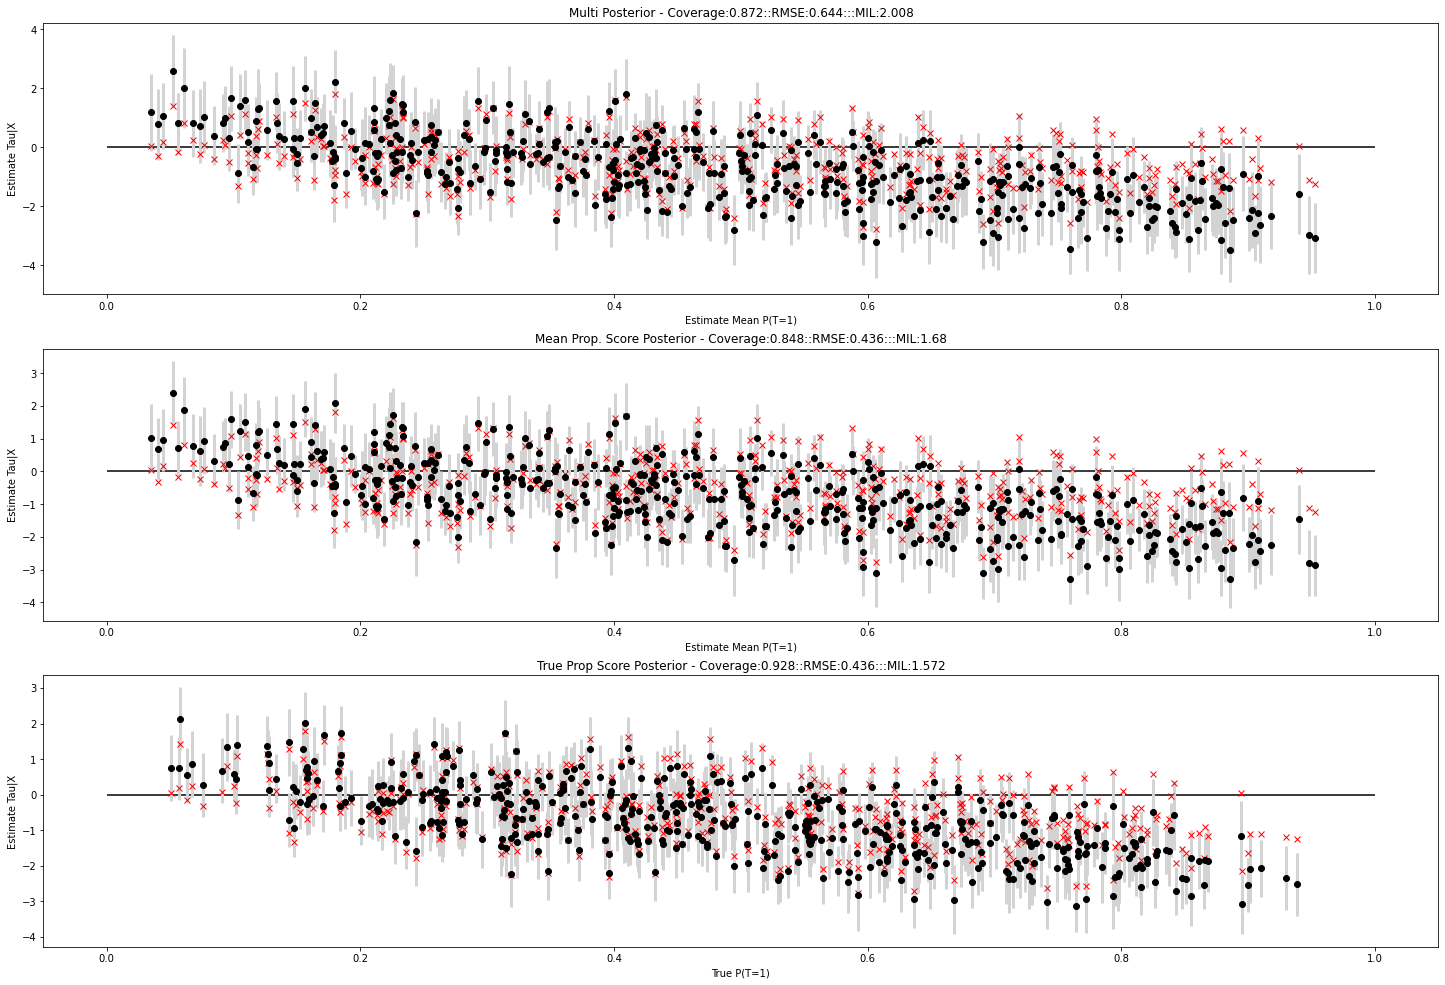

In [8]:
sub_N = n_in_study-1
X=analysis_obj.data[analysis_obj.predictors]
posterir_fp_Tau = np.matmul(
    X.to_numpy(), 
    analysis_obj.Y_i_star_posterior_propensity_linear_model_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)

plt.figure(figsize=(25,17))
## PLOT 1
plt.subplot(3, 1, 1)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
temp_fp = fp_Tau.loc[:, :sub_N]
#x=analysis_obj.data.loc[:,'Tau']
x=analysis_obj.propensity_score_trace["propensity_score"].mean(axis=0)
y=fp_Tau.mean(axis=0)
interval_high = np.quantile(fp_Tau, q=0.95, axis=0)
interval_low = np.quantile(fp_Tau, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x", color='red')
mp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
mp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_mp = 1-(sum(mp_max_violation)+sum(mp_min_violation))/len(mp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
emp = fp_Tau.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(emp*emp)), 3))    
_=plt.title("Multi Posterior - Coverage:" + str(coverage_mp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('Estimate Mean P(T=1)')

## PLOT 2
plt.subplot(3, 1, 2)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
post_mean_Y_i_star_mean_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_mean_propensity_linear_model_model, 
    trace_in=Y_i_star_mean_propensity_linear_model_trace, 
    predictors=predictors))
#x=analysis_obj.data.loc[:,'Tau']
x=y=analysis_obj.propensity_score_trace["propensity_score"].mean(axis=0)
y=post_mean_Y_i_star_mean_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x",color='red')
sp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
sp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_sp = 1-(sum(sp_max_violation)+sum(sp_min_violation))/len(sp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
esp = post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(esp*esp)), 3))    
_=plt.title("Mean Prop. Score Posterior - Coverage:" + str(coverage_sp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('Estimate Mean P(T=1)')

## PLOT 3
plt.subplot(3, 1, 3)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
post_mean_Y_i_star_true_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_true_propensity_linear_model_model, 
    trace_in=Y_i_star_true_propensity_linear_model_trace, 
    predictors=predictors))
x=analysis_obj.data.loc[:,'P(T=1)']
y=post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x",color='red')
tp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
tp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_tp = 1-(sum(tp_max_violation)+sum(tp_min_violation))/len(tp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
etp = post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(etp*etp)), 3))    
_=plt.title("True Prop Score Posterior - Coverage:" + str(coverage_tp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True P(T=1)')

### Credible Interval Length vs True P(T=1)

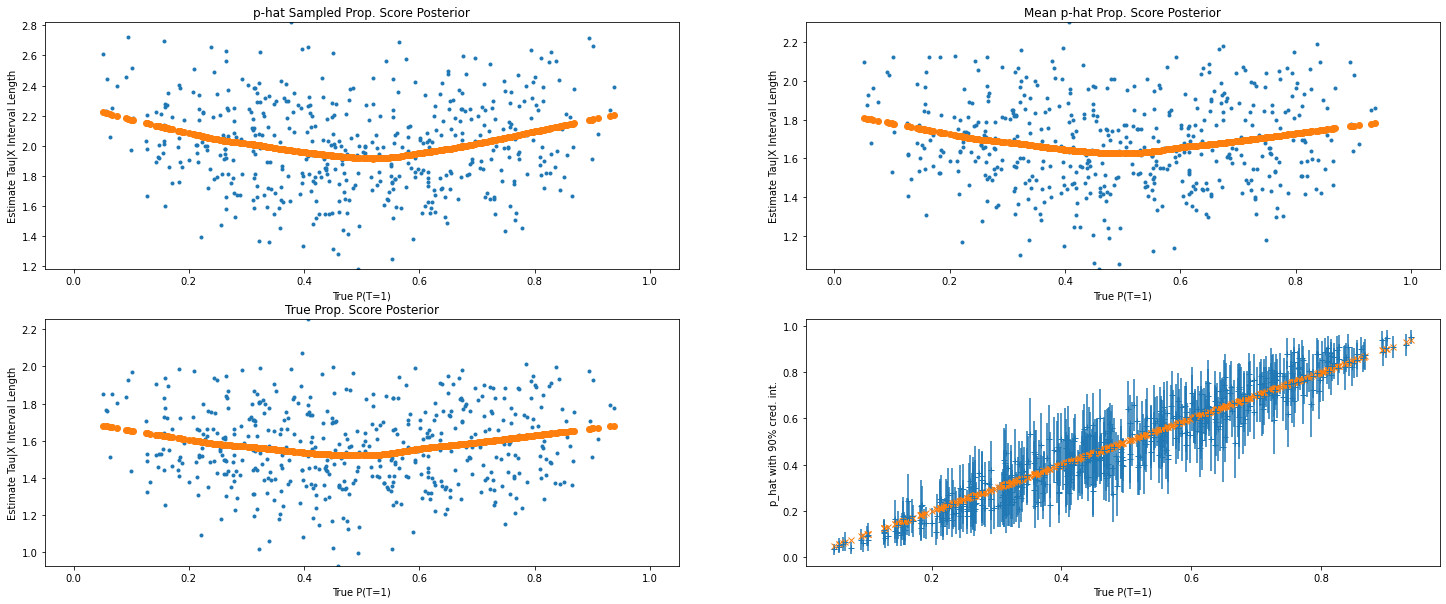

In [9]:
sub_N = n_in_study-1
X=analysis_obj.data[analysis_obj.predictors]
posterir_fp_Tau = np.matmul(
    X.to_numpy(), 
    analysis_obj.Y_i_star_posterior_propensity_linear_model_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)

plt.figure(figsize=(25,10))
## PLOT 1
plt.subplot(2, 2, 1)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
temp_fp = fp_Tau.loc[:, :sub_N]
x=x=analysis_obj.data.loc[:,'P(T=1)']
interval_high = np.quantile(fp_Tau, q=0.95, axis=0)
interval_low = np.quantile(fp_Tau, q=0.05, axis=0)
y=interval_high-interval_low
lowess = sm.nonparametric.lowess(y, x, frac=.5)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)
ynew = f(x)
plt.plot(x, y, '.')
plt.plot(x, ynew, 'o')
plt.ylim((min(y),max(y)))
_=plt.title("p-hat Sampled Prop. Score Posterior")
plt.ylabel('Estimate Tau|X Interval Length')
plt.xlabel('True P(T=1)')

## PLOT 2
plt.subplot(2, 2, 2)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
post_mean_Y_i_star_mean_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_mean_propensity_linear_model_model, 
    trace_in=Y_i_star_mean_propensity_linear_model_trace, 
    predictors=predictors))
x=x=analysis_obj.data.loc[:,'P(T=1)']
y=post_mean_Y_i_star_mean_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.05, axis=0)
y=interval_high-interval_low
lowess = sm.nonparametric.lowess(y, x, frac=.5)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)
ynew = f(x)
plt.plot(x, y, '.')
plt.plot(x, ynew, 'o')
plt.ylim((min(y),max(y)))
_=plt.title("Mean p-hat Prop. Score Posterior")
plt.ylabel('Estimate Tau|X Interval Length')
plt.xlabel('True P(T=1)')

## PLOT 3
plt.subplot(2, 2, 3)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
post_mean_Y_i_star_true_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_true_propensity_linear_model_model, 
    trace_in=Y_i_star_true_propensity_linear_model_trace, 
    predictors=predictors))
x=x=analysis_obj.data.loc[:,'P(T=1)']
interval_high = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.05, axis=0)
y=interval_high-interval_low
lowess = sm.nonparametric.lowess(y, x, frac=.5)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)
ynew = f(x)
plt.plot(x, y, '.')
plt.plot(x, ynew, 'o')
plt.ylim((min(y),max(y)))
_=plt.title("True Prop. Score Posterior")
plt.ylabel('Estimate Tau|X Interval Length')
plt.xlabel('True P(T=1)')

# Plot 4
plt.subplot(2, 2, 4)
x=analysis_obj.data.loc[:,'P(T=1)']
y=analysis_obj.propensity_score_trace["propensity_score"].mean(axis=0)
interval_high = np.quantile(analysis_obj.propensity_score_trace["propensity_score"], q=0.95, axis=0)
interval_low = np.quantile(analysis_obj.propensity_score_trace["propensity_score"], q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt="+")
_=plt.plot(x, x, "x")
plt.ylabel('p_hat with 90% cred. int.')
plt.xlabel('True P(T=1)')
plt.show()

### Tau-hat posterior Variance for p-hat sampled prop score vs Tau-hat posterior Variance for mean p-hat  prop score

Text(0.5, 0, 'Estimate Tau|X Varinace (mean p-hat)')

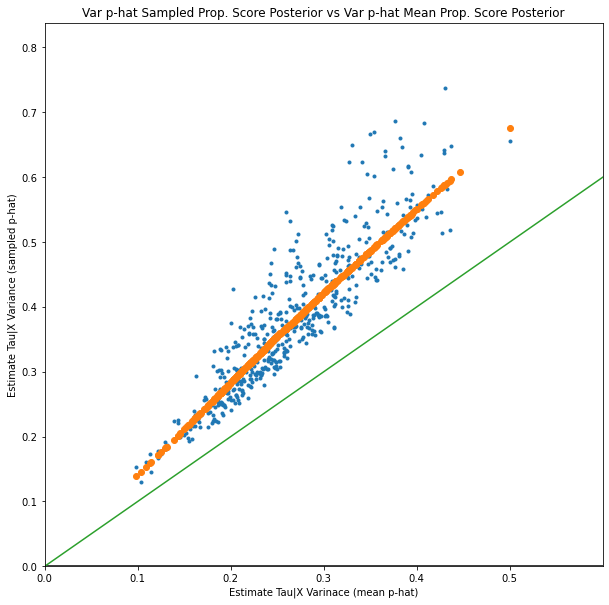

In [10]:
sub_N = n_in_study-1
X=analysis_obj.data[analysis_obj.predictors]
posterir_fp_Tau = np.matmul(
    X.to_numpy(), 
    analysis_obj.Y_i_star_posterior_propensity_linear_model_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)
post_mean_Y_i_star_mean_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_mean_propensity_linear_model_model, 
    trace_in=Y_i_star_mean_propensity_linear_model_trace, 
    predictors=predictors))

plt.figure(figsize=(10,10))
## PLOT 1
#plt.subplot(2, 2, 1)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
temp_fp = fp_Tau.loc[:, :sub_N]
x=post_mean_Y_i_star_mean_propensity_linear_model_trace.var(axis=0)
y=np.var(temp_fp, axis=0)
lowess = sm.nonparametric.lowess(y, x, frac=.5)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)
ynew = f(x)
plt.plot(x, y, '.')
plt.plot(x, ynew, 'o')
plt.plot([0,max([max(y),max(x)])],[0,max([max(y),max(x)])])
plt.ylim((0,max(y)+.1))#((min(y),max(y)))
plt.xlim((0,max(x)+.1))#((min(y),max(y)))

_=plt.title("Var p-hat Sampled Prop. Score Posterior vs Var p-hat Mean Prop. Score Posterior")
plt.ylabel('Estimate Tau|X Variance (sampled p-hat)')
plt.xlabel('Estimate Tau|X Varinace (mean p-hat)')

In [11]:
ps = analysis_obj.data.loc[:,'P(T=1)']
quantiles = np.quantile(ps, q=[.1,.2,.3,.4,.5,.6,.7,.8,.9])

Text(0.5, 0, 'T to C ratio bucketed by deciles')

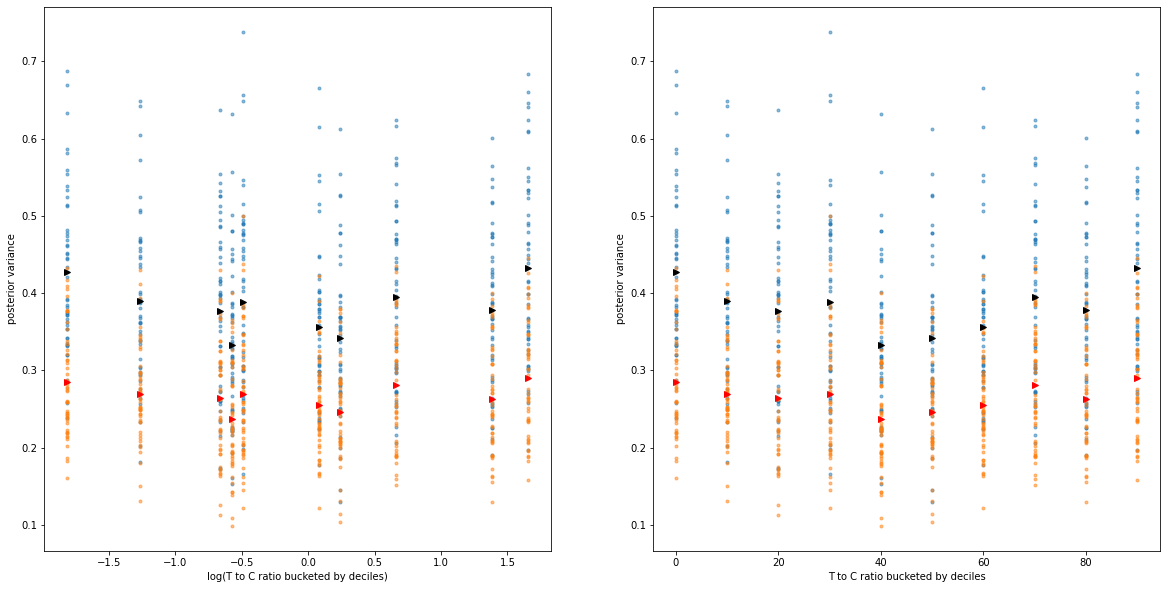

In [48]:
idx_0_10 = np.logical_and(ps>=0, ps<quantiles[0])
idx_10_20 = np.logical_and(ps>=quantiles[0], ps<quantiles[1])
idx_20_30 = np.logical_and(ps>=quantiles[1], ps<quantiles[2])
idx_30_40 = np.logical_and(ps>=quantiles[2], ps<quantiles[3])
idx_40_50 = np.logical_and(ps>=quantiles[3], ps<quantiles[4])
idx_50_60 = np.logical_and(ps>=quantiles[4], ps<quantiles[5])
idx_60_70 = np.logical_and(ps>=quantiles[5], ps<quantiles[6])
idx_70_80 = np.logical_and(ps>=quantiles[6], ps<quantiles[7])
idx_80_90 = np.logical_and(ps>=quantiles[7], ps<quantiles[8])
idx_90_100 = np.logical_and(ps>=quantiles[8], ps<1)

T_C_ratio = np.zeros(analysis_obj.data.shape[0])
T_C_ratio[idx_0_10] = sum(analysis_obj.data.loc[idx_0_10,'T'])/(-sum(analysis_obj.data.loc[idx_0_10,'T']-1))
T_C_ratio[idx_10_20] = sum(analysis_obj.data.loc[idx_10_20,'T'])/(-sum(analysis_obj.data.loc[idx_10_20,'T']-1))
T_C_ratio[idx_20_30] = sum(analysis_obj.data.loc[idx_20_30,'T'])/(-sum(analysis_obj.data.loc[idx_20_30,'T']-1))
T_C_ratio[idx_30_40] = sum(analysis_obj.data.loc[idx_30_40,'T'])/(-sum(analysis_obj.data.loc[idx_30_40,'T']-1))
T_C_ratio[idx_40_50] = sum(analysis_obj.data.loc[idx_40_50,'T'])/(-sum(analysis_obj.data.loc[idx_40_50,'T']-1))
T_C_ratio[idx_50_60] = sum(analysis_obj.data.loc[idx_50_60,'T'])/(-sum(analysis_obj.data.loc[idx_50_60,'T']-1))
T_C_ratio[idx_60_70] = sum(analysis_obj.data.loc[idx_60_70,'T'])/(-sum(analysis_obj.data.loc[idx_60_70,'T']-1))
T_C_ratio[idx_70_80] = sum(analysis_obj.data.loc[idx_70_80,'T'])/(-sum(analysis_obj.data.loc[idx_70_80,'T']-1))
T_C_ratio[idx_80_90] = sum(analysis_obj.data.loc[idx_80_90,'T'])/(-sum(analysis_obj.data.loc[idx_80_90,'T']-1))
T_C_ratio[idx_90_100] = sum(analysis_obj.data.loc[idx_90_100,'T'])/(-sum(analysis_obj.data.loc[idx_90_100,'T']-1))

T_C_ratio_label=np.zeros(analysis_obj.data.shape[0])
T_C_ratio_label[idx_0_10] = 0
T_C_ratio_label[idx_10_20]  = 10
T_C_ratio_label[idx_20_30]  = 20
T_C_ratio_label[idx_30_40]  = 30
T_C_ratio_label[idx_40_50]  = 40
T_C_ratio_label[idx_50_60]  = 50
T_C_ratio_label[idx_60_70]  = 60
T_C_ratio_label[idx_70_80]  = 70
T_C_ratio_label[idx_80_90]  = 80
T_C_ratio_label[idx_90_100] = 90

sub_N = n_in_study-1
X=analysis_obj.data[analysis_obj.predictors]
posterir_fp_Tau = np.matmul(
    X.to_numpy(), 
    analysis_obj.Y_i_star_posterior_propensity_linear_model_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)
post_mean_Y_i_star_mean_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_mean_propensity_linear_model_model, 
    trace_in=Y_i_star_mean_propensity_linear_model_trace, 
    predictors=predictors))

plt.figure(figsize=(20,10))
## PLOT 1
plt.subplot(1, 2, 1)
plt.plot(np.log(T_C_ratio), fp_Tau.var(axis=0), '.', alpha=.5)
plt.plot(np.log(T_C_ratio), post_mean_Y_i_star_mean_propensity_linear_model_trace.var(axis=0), '.', alpha=.5)

df = pd.DataFrame(
    {
        'mean_post_mean_variance':post_mean_Y_i_star_mean_propensity_linear_model_trace.var(axis=0),
        'multi_post_mean_variance':fp_Tau.var(axis=0),
        'T_C_ratio':T_C_ratio,
        'T_C_ratio_label': T_C_ratio_label
    }
)


plt.plot(
    np.log(df.groupby('T_C_ratio_label').mean().T_C_ratio), 
    df.groupby('T_C_ratio_label').mean().multi_post_mean_variance,
    '>', color='black')
plt.plot(
    np.log(df.groupby('T_C_ratio_label').mean().T_C_ratio), 
    df.groupby('T_C_ratio_label').mean().mean_post_mean_variance,
    '>', color='red')
plt.ylabel('posterior variance')
plt.xlabel('log(T to C ratio bucketed by deciles)')
## PLOT 2
plt.subplot(1, 2, 2)
plt.plot((T_C_ratio_label), fp_Tau.var(axis=0), '.', alpha=.5)
plt.plot((T_C_ratio_label), post_mean_Y_i_star_mean_propensity_linear_model_trace.var(axis=0), '.', alpha=.5)
plt.plot(
    df.groupby('T_C_ratio_label').mean().index.values, 
    df.groupby('T_C_ratio_label').mean().multi_post_mean_variance,
    '>', color='black')
plt.plot(
    df.groupby('T_C_ratio_label').mean().index.values, 
    df.groupby('T_C_ratio_label').mean().mean_post_mean_variance,
    '>', color='red')
#plt.ylim((0,3))
plt.ylabel('posterior variance')
plt.xlabel('T to C ratio bucketed by deciles')

Text(0.5, 0, 'tau')

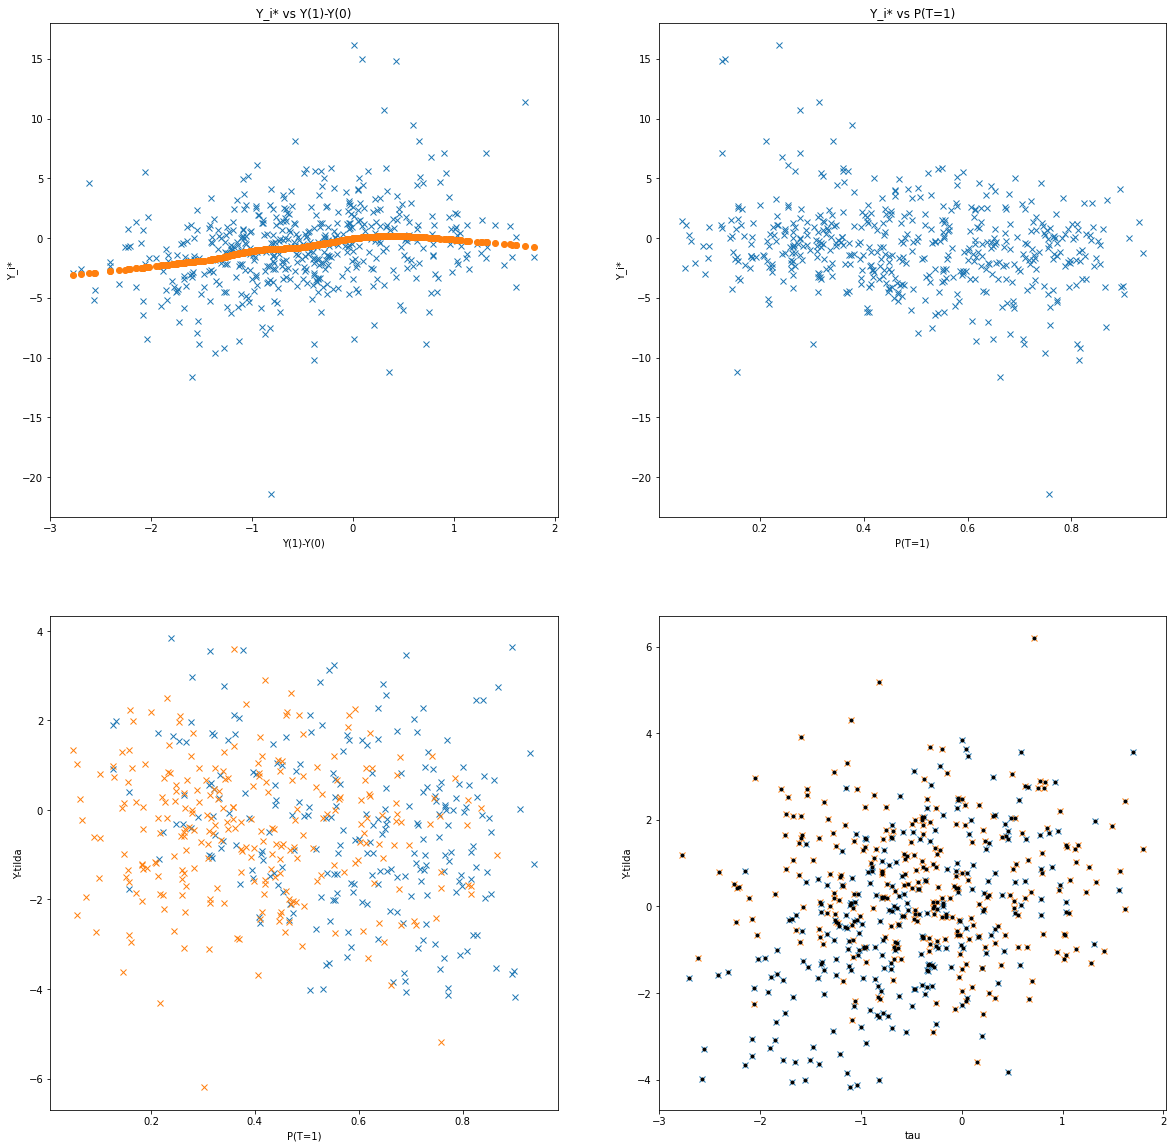

In [64]:
x=analysis_obj.data.loc[:,'Tau']
y=rlda.get_Y_i_star(
    Y_obs=analysis_obj.data.loc[:,'Y_obs'],
    W_i=analysis_obj.data.loc[:,'T'], 
    p=analysis_obj.data.loc[:,'P(T=1)'],
)
plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1)
plt.plot(x, y, 'x')
plt.title("Y_i* vs Y(1)-Y(0)")
plt.ylabel('Y_i*')
plt.xlabel('Y(1)-Y(0)')
#plt.ylim((-5,5))

#x=post_mean_Y_i_star_mean_propensity_linear_model_trace.var(axis=0)
#y=np.var(temp_fp, axis=0)
lowess = sm.nonparametric.lowess(y, x, frac=.5)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)
ynew = f(x)
plt.plot(x, ynew, 'o')

plt.subplot(2, 2, 2)
x=analysis_obj.data.loc[:,'P(T=1)']
plt.plot(x, y, 'x')
plt.title("Y_i* vs P(T=1)")
plt.ylabel('Y_i*')
plt.xlabel('P(T=1)')

plt.subplot(2, 2, 3)
x=analysis_obj.data.loc[:,'P(T=1)']
temp_y=analysis_obj.data.loc[:,'T']*y/(1/x)
plt.plot(x[temp_y!=0], temp_y[temp_y!=0], 'x')
temp_y=(1-analysis_obj.data.loc[:,'T'])*y/(1/(1-x))
plt.plot(x[temp_y!=0], temp_y[temp_y!=0], 'x')

#plt.title("Y_i* vs P(T=1)")
plt.ylabel('Y-tilda')
plt.xlabel('P(T=1)')

plt.subplot(2, 2, 4)
tau=analysis_obj.data.loc[:,'Tau']
temp_y=analysis_obj.data.loc[:,'T']*y/(1/x)
plt.plot(tau[temp_y!=0], temp_y[temp_y!=0], 'x')
temp_y=(analysis_obj.data.loc[:,'T']-1)*y/(1/(1-x))
plt.plot(tau[temp_y!=0], temp_y[temp_y!=0], 'x')

plt.plot(tau, analysis_obj.data.loc[:,'Y_obs'], '.', color='black')

#plt.title("Y_i* vs P(T=1)")
plt.ylabel('Y-tilda')
plt.xlabel('tau')

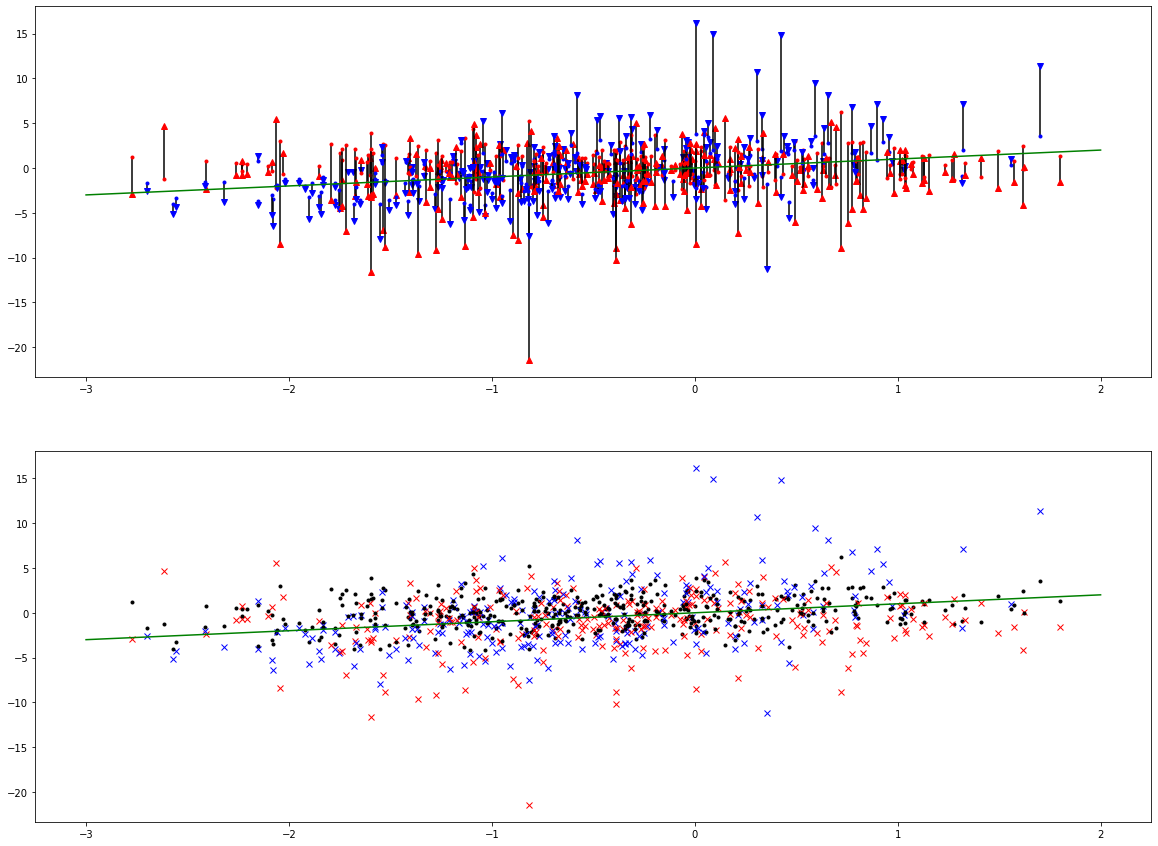

In [99]:
plt.figure(figsize=(20,15))
plt.subplot(2, 1, 1)

Y_i_star=rlda.get_Y_i_star(
    Y_obs=analysis_obj.data.loc[:,'Y_obs'],
    W_i=analysis_obj.data.loc[:,'T'], 
    p=analysis_obj.data.loc[:,'P(T=1)'],
)
Y_obs=analysis_obj.data.loc[:,'Y_obs']
W=analysis_obj.data.loc[:, 'T']

for i in range(analysis_obj.data.shape[0]):
    
    x = [analysis_obj.data.loc[i, 'Tau'], analysis_obj.data.loc[i, 'Tau']]
    y = [Y_i_star[i], Y_obs[i]]
    plt.plot(x,y, 'k-')
    if W[i]==1:
        plt.plot(x[0],Y_i_star[i], 'v', color='blue')
        plt.plot(analysis_obj.data.loc[i, 'Tau'], analysis_obj.data.loc[i, 'Y_obs'], '.', color='blue')
    else:
        plt.plot(x[0],Y_i_star[i], '^', color='red')
        plt.plot(analysis_obj.data.loc[i, 'Tau'], analysis_obj.data.loc[i, 'Y_obs'], '.', color='red')

plt.plot([-3,2],[-3,2], color='green')

plt.subplot(2, 1, 2)
for i in range(analysis_obj.data.shape[0]):
    
    if W[i] == 1:
        term=analysis_obj.data.loc[i, 'P(T=1)']
        #print(Y_i_star[i]*term)
        x = [analysis_obj.data.loc[i, 'Tau'], analysis_obj.data.loc[i, 'Tau']]
        #print(x)
        y = [Y_i_star[i]*term, Y_obs[i]]
        #print(y)
        plt.plot(x,y, 'k-', color='black')
        plt.plot(x[0],Y_i_star[i], 'x', color='blue')
        plt.plot(analysis_obj.data.loc[i, 'Tau'], analysis_obj.data.loc[i, 'Y_obs'], '.', color='black')

    else:
        term=analysis_obj.data.loc[i, 'P(T=1)']-1
        x = [analysis_obj.data.loc[i, 'Tau'], analysis_obj.data.loc[i, 'Tau']]
        y = [Y_i_star[i]*term, Y_obs[i]]
        plt.plot(x,y, 'k-', color='black')
        plt.plot(x[0],Y_i_star[i], 'x', color='red')
        plt.plot(analysis_obj.data.loc[i, 'Tau'], analysis_obj.data.loc[i, 'Y_obs'], '.', color='black')
plt.plot([-3,2],[-3,2], color='green')

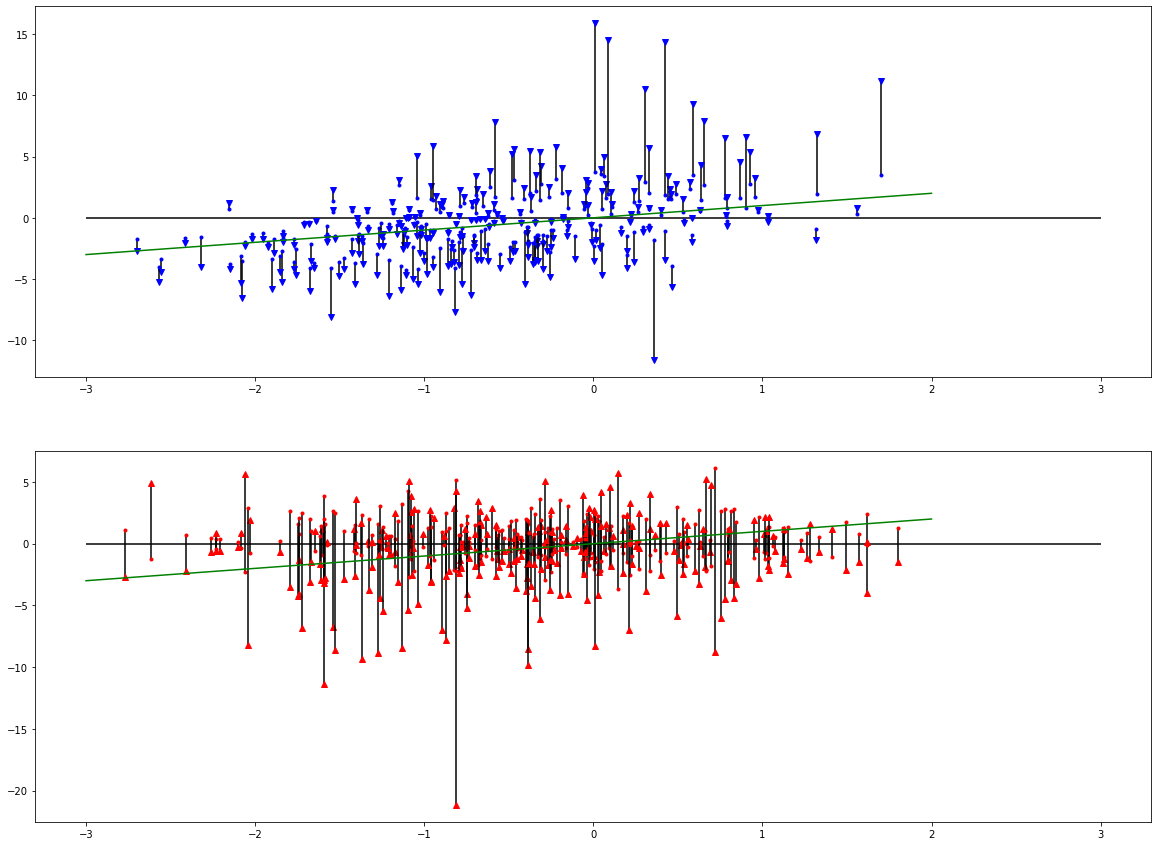

In [106]:
plt.figure(figsize=(20,15))
plt.subplot(2, 1, 1)

Y_obs=analysis_obj.data.loc[:,'Y_obs']+20

Y_obs = Y_obs-np.mean(Y_obs)

Y_i_star=rlda.get_Y_i_star(
    Y_obs=Y_obs,
    W_i=analysis_obj.data.loc[:,'T'], 
    p=analysis_obj.data.loc[:,'P(T=1)'],
)
W=analysis_obj.data.loc[:, 'T']

for i in range(analysis_obj.data.shape[0]):
    
    x = [analysis_obj.data.loc[i, 'Tau'], analysis_obj.data.loc[i, 'Tau']]
    y = [Y_i_star[i], Y_obs[i]]
    
    if W[i]==1:
        plt.plot(x,y, 'k-')
        plt.plot(x[0],Y_i_star[i], 'v', color='blue')
        plt.plot(analysis_obj.data.loc[i, 'Tau'], Y_obs[i], '.', color='blue')
plt.plot([-3,2],[-3,2], color='green')
plt.hlines(y=0, xmin=-3, xmax=3)

plt.subplot(2, 1, 2)
for i in range(analysis_obj.data.shape[0]):
    
    x = [analysis_obj.data.loc[i, 'Tau'], analysis_obj.data.loc[i, 'Tau']]
    y = [Y_i_star[i], Y_obs[i]]
    if W[i]==0:
        plt.plot(x,y, 'k-')
        plt.plot(x[0],Y_i_star[i], '^', color='red')
        plt.plot(analysis_obj.data.loc[i, 'Tau'], Y_obs[i], '.', color='red')

plt.plot([-3,2],[-3,2], color='green')
plt.hlines(y=0, xmin=-3, xmax=3)



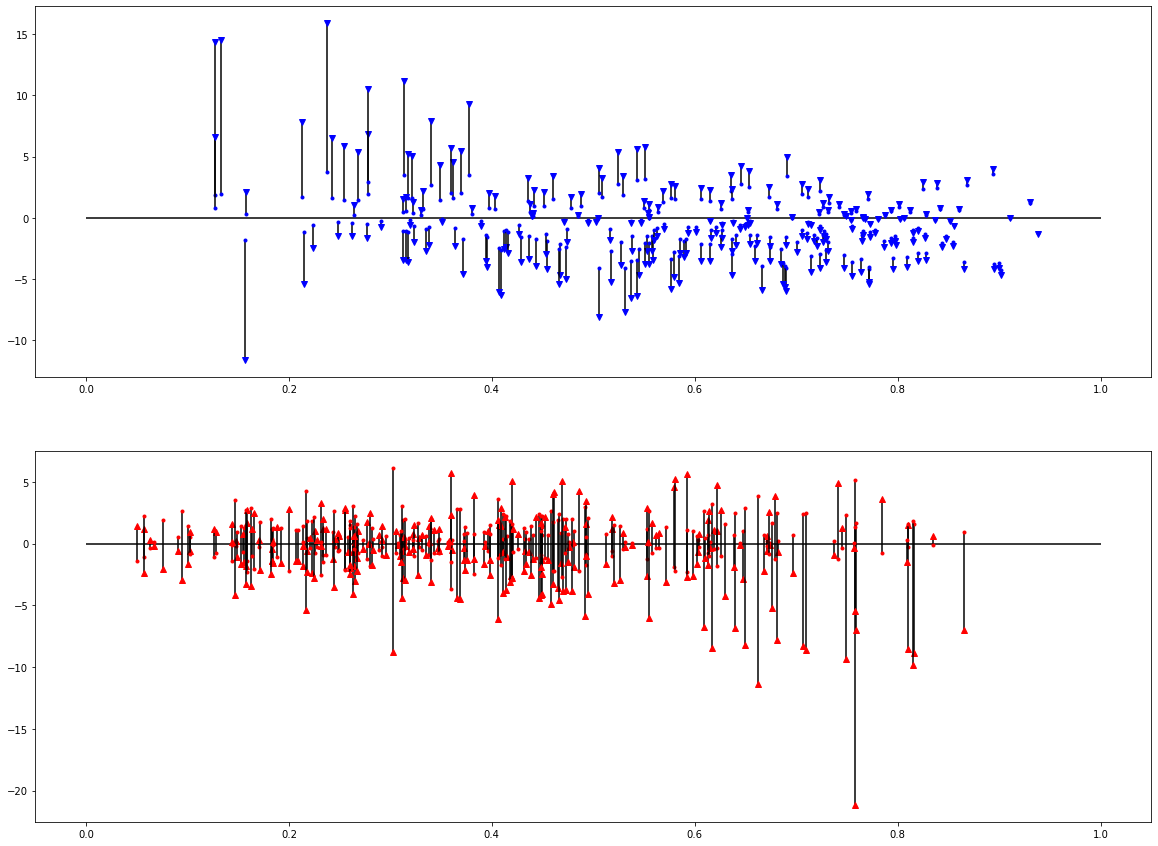

In [109]:
plt.figure(figsize=(20,15))
plt.subplot(2, 1, 1)

Y_obs=analysis_obj.data.loc[:,'Y_obs']+20

Y_obs = Y_obs-np.mean(Y_obs)

Y_i_star=rlda.get_Y_i_star(
    Y_obs=Y_obs,
    W_i=analysis_obj.data.loc[:,'T'], 
    p=analysis_obj.data.loc[:,'P(T=1)'],
)
W=analysis_obj.data.loc[:, 'T']

for i in range(analysis_obj.data.shape[0]):
    
    x = [analysis_obj.data.loc[i, 'P(T=1)'], analysis_obj.data.loc[i, 'P(T=1)']]
    y = [Y_i_star[i], Y_obs[i]]
    
    if W[i]==1:
        plt.plot(x,y, 'k-')
        plt.plot(x[0],Y_i_star[i], 'v', color='blue')
        plt.plot(analysis_obj.data.loc[i, 'P(T=1)'], Y_obs[i], '.', color='blue')
#plt.plot([-3,2],[-3,2], color='green')
plt.hlines(y=0, xmin=0, xmax=1)

plt.subplot(2, 1, 2)
for i in range(analysis_obj.data.shape[0]):
    
    x = [analysis_obj.data.loc[i, 'P(T=1)'], analysis_obj.data.loc[i, 'P(T=1)']]
    y = [Y_i_star[i], Y_obs[i]]
    if W[i]==0:
        plt.plot(x,y, 'k-')
        plt.plot(x[0],Y_i_star[i], '^', color='red')
        plt.plot(analysis_obj.data.loc[i, 'P(T=1)'], Y_obs[i], '.', color='red')

#plt.plot([-3,2],[-3,2], color='green')
plt.hlines(y=0, xmin=0, xmax=1)


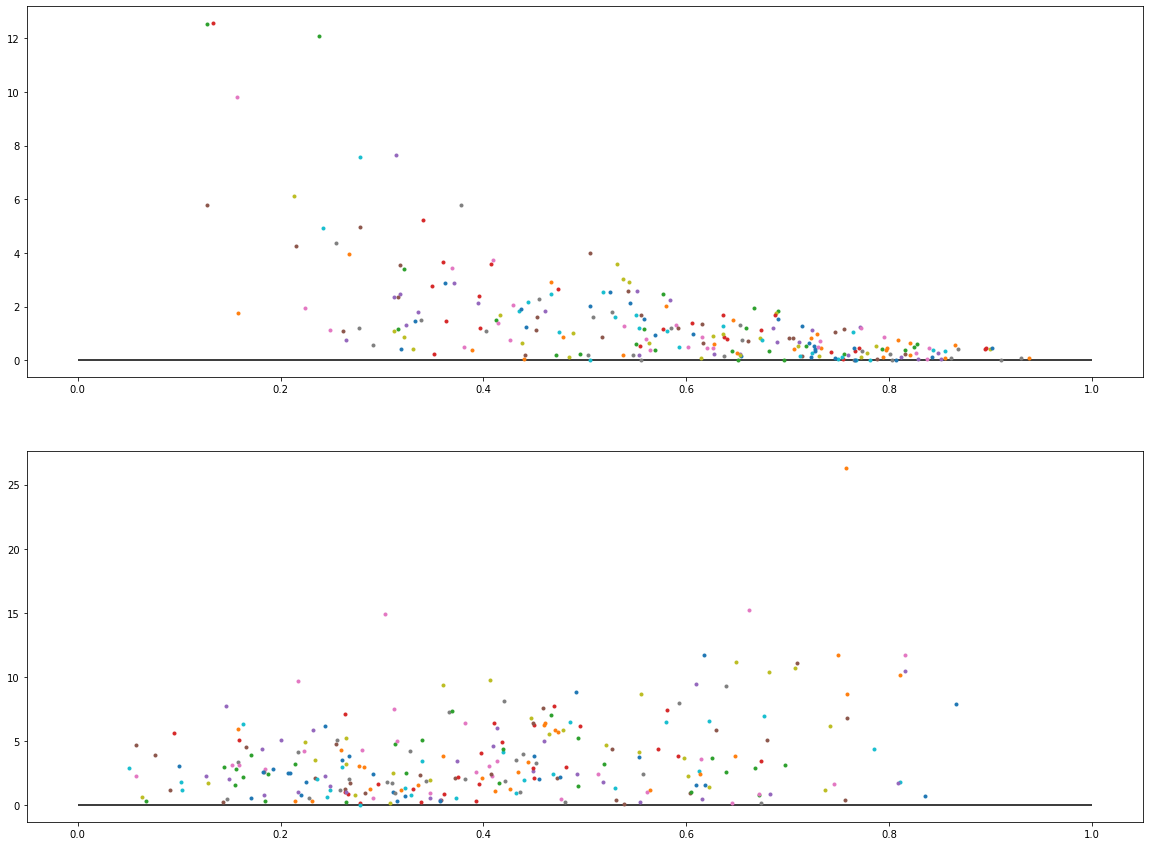

In [121]:
plt.figure(figsize=(20,15))
plt.subplot(2, 1, 1)

Y_obs=analysis_obj.data.loc[:,'Y_obs']+20

Y_obs = Y_obs-np.mean(Y_obs)

Y_i_star=rlda.get_Y_i_star(
    Y_obs=Y_obs,
    W_i=analysis_obj.data.loc[:,'T'], 
    p=analysis_obj.data.loc[:,'P(T=1)'],
)
W=analysis_obj.data.loc[:, 'T']

for i in range(analysis_obj.data.shape[0]):
    
    x = analysis_obj.data.loc[i, 'P(T=1)']
    y = np.abs(Y_i_star[i] - Y_obs[i])
    
    if W[i]==1:
        plt.plot(x,y, '.')
        #plt.plot(x[0],Y_i_star[i], 'v', color='blue')
        #plt.plot(analysis_obj.data.loc[i, 'P(T=1)'], Y_obs[i], '.', color='blue')
#plt.plot([-3,2],[-3,2], color='green')
plt.hlines(y=0, xmin=0, xmax=1)

plt.subplot(2, 1, 2)
for i in range(analysis_obj.data.shape[0]):
    
    x = analysis_obj.data.loc[i, 'P(T=1)']
    y = np.abs(Y_i_star[i] - Y_obs[i])
    if W[i]==0:
        plt.plot(x,y, '.')
        #plt.plot(x[0],Y_i_star[i], '^', color='red')
        #plt.plot(analysis_obj.data.loc[i, 'P(T=1)'], Y_obs[i], '.', color='red')

#plt.plot([-3,2],[-3,2], color='green')
plt.hlines(y=0, xmin=0, xmax=1)


In [117]:
np.cov(x,x/100)

array([[1.06003398e+00, 1.06003398e-02],
       [1.06003398e-02, 1.06003398e-04]])